In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_dl
import tensorflow as tf

import davis_tracking

c:\users\terry\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading Event Data

The training data has been recorded as a bunch of events from the DAVIS camera as a ball rolls around.  There are a few sample data files in this repository (in the `dataset` directory), and the complete dataset can be found on the ABR GPU server in `/home/tcstewar/davis_data`.  Each sample consists of the events (`<name>.events`) and an accompanying set of labels which give the ground truth of where the ball is (`<name>.events.label`).  The ground truth consists of keyframe information (i.e. the location of the ball at particular points in time.)

Since this is event-based data, there are no frames.  So, to train our network, we need to convert this into more traditional training data.  If we assume that each event will be filtered by a low-pass filter, we can generate a set of images that would result from that event stream.  Importantly, we can generate these images at any time step we like!


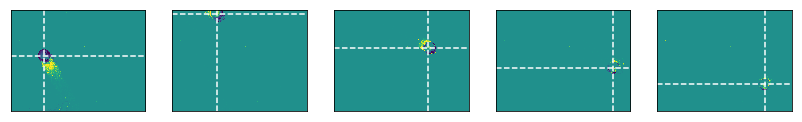

In [2]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.1,                  # time step between images
                                                  decay_time=0.01,         # low pass filter time constant
                                                  separate_channels=False, # do positive and negative spikes separately
                                                  saturation=10,           # clip values to this range
                                                  merge=1)                 # merge pixels together to reduce size


N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

You can adjust the low-pass filter on the input:

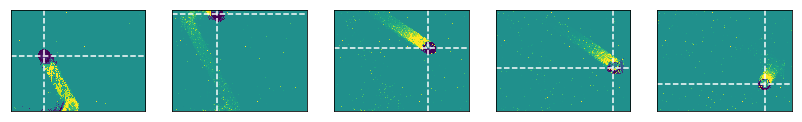

In [3]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.1,                  # time step between images
                                                  decay_time=0.1,          # low pass filter time constant
                                                  separate_channels=False, # do positive and negative spikes separately
                                                  saturation=10,           # clip values to this range
                                                  merge=1)                 # merge pixels together to reduce size


N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

You can also separate the positive and negative events into two separate channels.  This is likely a good thing, as event cameras tend not to have a perfect balance between positive and negative spiking sensitivity, so there's no reason they should be subtracted from one another.

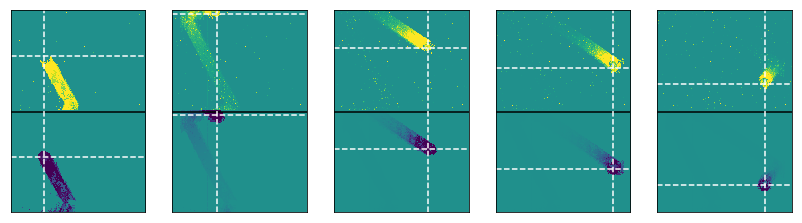

In [4]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.1,                  # time step between images
                                                  decay_time=0.1,          # low pass filter time constant
                                                  separate_channels=True,  # do positive and negative spikes separately
                                                  saturation=10,           # clip values to this range
                                                  merge=1)                 # merge pixels together to reduce size


N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

You can also clip the values while the data is being generated.  This is slightly different from clipping after the data is generated (as the low-pass filter will be affected).  This might be important for cases where a *very* large number of spikes happen to one pixel, depending on how the input will be handled.

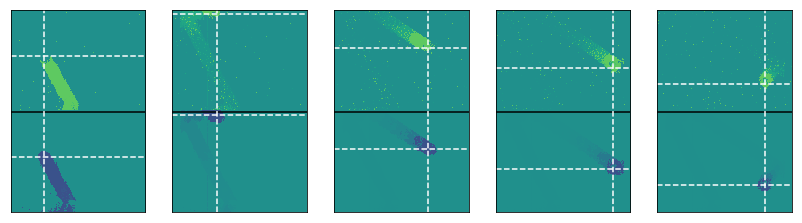

In [5]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.1,                  # time step between images
                                                  decay_time=0.1,          # low pass filter time constant
                                                  separate_channels=True,  # do positive and negative spikes separately
                                                  saturation=0.5,          # clip values to this range
                                                  merge=1)                 # merge pixels together to reduce size


N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

Finally, we can also down-sample the image.  Instead of just dropping spikes, we do this by averaging together the inputs within a square region (size `(merge,merge)`).  This is the same as treating all spikes in that area as the same input.

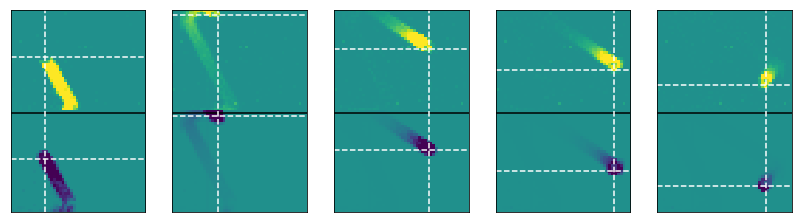

In [6]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.1,                  # time step between images
                                                  decay_time=0.1,          # low pass filter time constant
                                                  separate_channels=True,  # do positive and negative spikes separately
                                                  saturation=10,           # clip values to this range
                                                  merge=5)                 # merge pixels together to reduce size


N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index], vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

The data returned by `load_data` is cached so that it does not need to be re-calculated.  These cache files are placed in the same directory as the data files, and end in `.cache.npz`.

For the target values, we get the x,y location (marked with dotted lines above).  We also get an indication as to whether the ball is present, and the radius of the ball.  The `load_data` function currently only returns data where the ball is present, and the radius does not change much, so those last two values aren't all that useful.

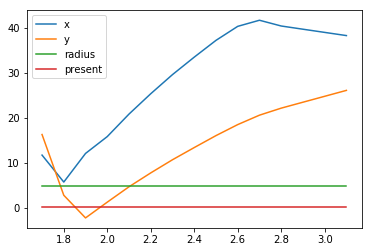

In [7]:
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present']);

## Building a ConvNet

Now let's build a Convnet to track the ball given the image.  For this notebook, we'll just use the one training sample, using the even points as training data and the odd points as test data.  For a more realistic example, I've been using the leave-one-out approach (train on all the data sets except one, test on the left out one).

Let's also crank up `merge` to a large value, just to keep things small.

In [38]:
times, images, targets = davis_tracking.load_data('../dataset/retinaTest95.events',
                                                  dt=0.01,                 # time step between images
                                                  decay_time=0.01,         # low pass filter time constant
                                                  separate_channels=True,  # do positive and negative spikes separately
                                                  saturation=10,           # clip values to this range
                                                  merge=10)                # merge pixels together to reduce size
targets = targets[:, :2]

Now we create the convnet.  I'm using a helper class for reasons that will be apparent in the next section, where we start splitting things spatially.  But for now, it's pretty much exactly the same approach as in https://www.nengo.ai/nengo-loihi/v0.4.0/examples/mnist_convnet.html

In [72]:
input_shape = (2, 18, 24)
dimensions = input_shape[0]*input_shape[1]*input_shape[2]

max_rate = 100
amp = 1 / max_rate

model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None

    inp = nengo.Node([0]*dimensions)

    convnet = davis_tracking.ConvNet(nengo.Network(label='convnet'))
    
    convnet.make_input_layer(input_shape)
    nengo.Connection(inp, convnet.input)
    
    convnet.make_middle_layer(n_features=60, n_parallel=1, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_middle_layer(n_features=60, n_parallel=1, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_output_layer(2)
    
    out = nengo.Node(None, size_in=2)
    nengo.Connection(convnet.output, out)

    p_out = nengo.Probe(out)

Let's see what we created.

In [31]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

So that's a pretty standard network.  The image starts at 24x18 in size, then goes through two convolutional layers, each with 60 features, a kernel size of 3x3 and a stride of 1x1.  Then all the accumulated data goes to a 2-dimensional output (the x,y poistion).

Let's quickly check if this works, and then look at the parameters we can use to adjust the network.

In [36]:
inputs_train = images[::2]
inputs_test = images[1::2]
targets_train = targets[::2]
targets_test = targets[1::2]

minibatch_size = 200
n_epochs = 400
learning_rate = 1e-4


N = len(inputs_train)
n_steps = int(np.ceil(N/minibatch_size))
dl_train_data = {inp: np.resize(inputs_train, (minibatch_size, n_steps, dimensions)),
                 p_out: np.resize(targets_train, (minibatch_size, n_steps, 2))}
N = len(inputs_test)
n_steps = int(np.ceil(N/minibatch_size))
dl_test_data = {inp: np.resize(inputs_test, (minibatch_size, n_steps, dimensions)),
                p_out: np.resize(targets_test, (minibatch_size, n_steps, 2))}
with nengo_dl.Simulator(model, minibatch_size=minibatch_size) as sim:
    loss_pre = sim.loss(dl_test_data)
    print('loss pre:', loss_pre)

    sim.train(dl_train_data, tf.train.RMSPropOptimizer(learning_rate=learning_rate),
          n_epochs=n_epochs)

    loss_post = sim.loss(dl_test_data)
    print('loss post:', loss_post)

    sim.run_steps(n_steps, data=dl_test_data)



Build finished in 0:00:00                                                      
| #               Optimizing graph: creating signals                  | 0:00:00

c:\users\terry\documents\github\nengo-dl\nengo_dl\simulator.py:94: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Optimization finished in 0:00:00                                               
|###           Constructing graph: build stage (5%)              | ETA: 0:00:03#########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

c:\users\terry\documents\github\nengo-dl\nengo_dl\transform_builders.py:43: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  "to channels_last=True", UserWarning)


Construction finished in 0:00:01                                               
Calculation finished in 0:00:12                                                
loss pre: 137.96162
Training finished in 0:07:20 (loss: 0.8145)                                    
Calculation finished in 0:00:02                                                
loss post: 1.8510652
Simulation finished in 0:00:10                                                 


[17.10676252 10.33860758]


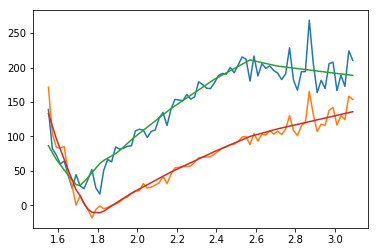

In [49]:
data = sim.data[p_out].reshape(-1,2)[:len(targets_test)]
plt.plot(times[1::2], data*10)
plt.plot(times[1::2], targets_test*10)

rmse = np.sqrt(np.mean((data-targets_test)**2, axis=0))*10
print(rmse)

The basic idea seems to work.  But, the ensembles are too large to fit on Loihi.  

In [73]:
print([ens.n_neurons for ens in model.all_ensembles])

[21120, 16800]


So, let's split the ensembles up.

We do this by specifying `n_parallel`.  This indicates how many parallel Ensembles to create, each one having `n_features` features.  This is the same idea as `n_parallel` in https://www.nengo.ai/nengo-loihi/v0.4.0/examples/mnist_convnet.html 

When we do this with multiple layers, we can also specify `n_local`.  This indicates how many of the parallel ensembles in the *previous* layer will the ensembles in the current layer be connected to.  If `n_local` equals `n_parallel` in the previous layer, then we're the same as a normal convnet.  However, since we may wish to control how many connections exist in the model, we can control this with `n_local`.

In [74]:
input_shape = (2, 18, 24)
dimensions = input_shape[0]*input_shape[1]*input_shape[2]

max_rate = 100
amp = 1 / max_rate

model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None

    inp = nengo.Node([0]*dimensions)

    convnet = davis_tracking.ConvNet(nengo.Network(label='convnet'))
    
    convnet.make_input_layer(input_shape)
    nengo.Connection(inp, convnet.input)
    
    convnet.make_middle_layer(n_features=20, n_parallel=3, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_middle_layer(n_features=30, n_parallel=2, n_local=2,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_output_layer(2)
    
    out = nengo.Node(None, size_in=2)
    nengo.Connection(convnet.output, out)

    p_out = nengo.Probe(out)

In [75]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

However, this is still too big.

In [76]:
print([ens.n_neurons for ens in model.all_ensembles])

[7040, 7040, 7040, 8400, 8400]


One option would be to break things up even smaller.

In [90]:
input_shape = (2, 18, 24)
dimensions = input_shape[0]*input_shape[1]*input_shape[2]

max_rate = 100
amp = 1 / max_rate

model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None

    inp = nengo.Node([0]*dimensions)

    convnet = davis_tracking.ConvNet(nengo.Network(label='convnet'))
    
    convnet.make_input_layer(input_shape)
    nengo.Connection(inp, convnet.input)
    
    convnet.make_middle_layer(n_features=2, n_parallel=30, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_middle_layer(n_features=3, n_parallel=20, n_local=2,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_output_layer(2)
    
    out = nengo.Node(None, size_in=2)
    nengo.Connection(convnet.output, out)

    p_out = nengo.Probe(out)
    
print([ens.n_neurons for ens in model.all_ensembles])

[704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840]


In [68]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

However, there's also another option: separating the Ensembles spatially.

## Building a Spatial ConvNet

Now we add some parameters to the `make_input_layer` call.  In particular, we split the image apart into (overlapping) sub-images.  To do this, we specify a `spatial_stride` and `spatial_size`:

In [87]:
input_shape = (2, 18, 24)
dimensions = input_shape[0]*input_shape[1]*input_shape[2]

max_rate = 100
amp = 1 / max_rate

model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None

    inp = nengo.Node([0]*dimensions)

    convnet = davis_tracking.ConvNet(nengo.Network(label='convnet'))
    
    convnet.make_input_layer(input_shape,
                             spatial_size=(12,12),
                             spatial_stride=(6,6))
    nengo.Connection(inp, convnet.input)
    
    convnet.make_middle_layer(n_features=10, n_parallel=6, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_middle_layer(n_features=15, n_parallel=4, n_local=3,
                              kernel_stride=(1,1), kernel_size=(3, 3))
    
    convnet.make_output_layer(2)
    
    out = nengo.Node(None, size_in=2)
    nengo.Connection(convnet.output, out)

    p_out = nengo.Probe(out)
    
print([ens.n_neurons for ens in model.all_ensembles])

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960]


In [88]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

This is an alternate way of keeping the Ensembles small.  However, it's not clear yet which way is better!  Yay research.

## Next Steps

The next aspect being worked on is to change the output format.  Instead of producing an x,y vector, it may be more natural to produce a heatmap as an output.  I see two options for this:

1) have the output be an image the same size as the input but with a gaussian bump at the location (and size of) the ball.  Train as normal.

2) have the output be an image the same size as the input, but all zeros with a single 1 at the location of the ball.  Train using crossentropy, as this is sort of a classification task.

For both cases there would be an `argmax` call on the output to turn it into an x,y location so we can compute the error.